In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install -q kaggle

In [ ]:
import json
import os

os.makedirs('/root/.kaggle', exist_ok=True)
credentials = {"username":"jonasthalmeier","key":"33b03d98f98eee16369a58a286742b19"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(credentials, f)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d michiard/aerial-cactus
# Unzip a file named "aerial-cactus.zip" into the `/content/` directory
!unzip /content/aerial-cactus.zip -d /content/aerial-cactus/

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/aerial-cactus/train/train/b562d502ebe643a3225702fa5d959e42.jpg  
  inflating: /content/aerial-cactus/train/train/b563db810a04ea29e98666440f6eefc0.jpg  
  inflating: /content/aerial-cactus/train/train/b56ebdd452de4737c905008ade73c9b1.jpg  
  inflating: /content/aerial-cactus/train/train/b5759a7a465f9669bfaca416067fbe4a.jpg  
  inflating: /content/aerial-cactus/train/train/b578642acb038eb2cf6f4c4967261809.jpg  
  inflating: /content/aerial-cactus/train/train/b57e5b6adc7ceb7895c1df956109463d.jpg  
  inflating: /content/aerial-cactus/train/train/b57fdf31347f2c18d2748985c6f5a747.jpg  
  inflating: /content/aerial-cactus/train/train/b583ee8f7d13be8df2b3ed4a756dac70.jpg  
  inflating: /content/aerial-cactus/train/train/b58717e6aaa8fb438344c41ddae28ee4.jpg  
  inflating: /content/aerial-cactus/train/train/b58d8074171dbb99a4b67ecfd17577f9.jpg  
  inflating: /content/aerial-cactus/train/train/b595cf55acc1cca52fb5420bc4187b47

In [ ]:
df = pd.read_csv('/content/aerial-cactus/train.csv')
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")   # Ensure 3 channels
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    return img_array

# Folder where augmented images are stored
directory = '/content/aerial-cactus/train/train'

# List to store processed images
processed_images = []
image_ids = []  # List to store image filenames/ids

# Process each image in the dataframe
for img_name in df['id']:
    img_path = os.path.join(directory, img_name)  # Full image path

    # Preprocess the image
    processed_image = load_and_preprocess_image(img_path)

    # Append to the list
    processed_images.append(processed_image)
    image_ids.append(img_name)

# Convert list to NumPy array (shape: [num_images, height, width, channels])
processed_images_array = np.array(processed_images)

# Optionally, print the shape of the resulting array
print(f"Processed images array shape: {processed_images_array.shape}")


Processed images array shape: (17500, 32, 32, 3)


## SPLIT IN TRAIN TEST

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Split the DataFrame FIRST
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['has_cactus'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['has_cactus'], random_state=42)

# 2. Define a function to load images for a given DataFrame
def load_images_from_df(df, directory):
    images = []
    for img_name in df['id']:
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)

# 3. Load images ONLY for each split
X_train = load_images_from_df(train_df, directory)
X_val = load_images_from_df(val_df, directory)
X_test = load_images_from_df(test_df, directory)

# Get labels
y_train = train_df['has_cactus'].values
y_val = val_df['has_cactus'].values
y_test = test_df['has_cactus'].values

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes - Train: (11200, 32, 32, 3), Val: (2800, 32, 32, 3), Test: (3500, 32, 32, 3)


In [ ]:
from PIL import ImageOps
import numpy as np
from tqdm import tqdm

def augment_and_balance(X_train, y_train, train_df, target_dir='/content/balanced_train'):
    """
    Augment minority class images to balance the dataset.
    Returns balanced X_train, y_train, and updated DataFrame.
    """
    # Create directory for augmented images
    os.makedirs(target_dir, exist_ok=True)

    # Count class distribution
    class_counts = np.bincount(y_train)
    majority_count = max(class_counts)
    minority_class = np.argmin(class_counts)

    print(f"Original counts: Class 0 - {class_counts[0]}, Class 1 - {class_counts[1]}")
    print(f"Augmenting class {minority_class} to {majority_count} samples")

    # Get indices of minority class
    minority_indices = np.where(y_train == minority_class)[0]
    needed = majority_count - class_counts[minority_class]

    # Storage for new data
    new_images = []
    new_labels = []
    new_df_rows = []

    # Augmentation transformations
    def apply_augmentations(img_array):
        """Generate augmented versions of an image"""
        img = Image.fromarray((img_array*255).astype('uint8'))

        # Horizontal flip
        hflip = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))/255

        # Vertical flip
        vflip = np.array(img.transpose(Image.FLIP_TOP_BOTTOM))/255


        return [hflip, vflip]

    # Apply augmentations
    augmented_count = 0
    with tqdm(total=needed, desc="Augmenting images") as pbar:
        while augmented_count < needed:
            for idx in minority_indices:
                if augmented_count >= needed:
                    break

                original_img = X_train[idx]
                augmented_versions = apply_augmentations(original_img)

                for aug_img in augmented_versions:
                    if augmented_count >= needed:
                        break

                    # Save augmented image
                    img_id = train_df.iloc[idx]['id']
                    new_id = f"aug_{augmented_count}_{img_id}"
                    new_path = os.path.join(target_dir, new_id)
                    Image.fromarray((aug_img).astype('uint8')).save(new_path)

                    # Store new data
                    new_images.append(aug_img)
                    new_labels.append(minority_class)
                    new_df_rows.append({
                        'id': new_id,
                        'has_cactus': minority_class
                    })

                    augmented_count += 1
                    pbar.update(1)

    # Combine with original data
    balanced_X = np.concatenate([X_train, np.array(new_images)])
    balanced_y = np.concatenate([y_train, np.array(new_labels)])

    # Create balanced DataFrame
    balanced_df = pd.concat([
        train_df,
        pd.DataFrame(new_df_rows)
    ], ignore_index=True)

    # Verify balance
    final_counts = np.bincount(balanced_y)
    print(f"Final counts: Class 0 - {final_counts[0]}, Class 1 - {final_counts[1]}")

    return balanced_X, balanced_y, balanced_df

# Apply augmentation
balanced_X_train, balanced_y_train, balanced_train_df = augment_and_balance(
    X_train, y_train, train_df)

# Verify shapes
print(f"Balanced X_train shape: {balanced_X_train.shape}")
print(f"Balanced y_train shape: {balanced_y_train.shape}")

Original counts: Class 0 - 2793, Class 1 - 8407
Augmenting class 0 to 8407 samples


Augmenting images: 100%|██████████| 5614/5614 [00:03<00:00, 1508.99it/s]


Final counts: Class 0 - 8407, Class 1 - 8407
Balanced X_train shape: (16814, 32, 32, 3)
Balanced y_train shape: (16814,)


In [ ]:
#check percentage of value_counts=0
print(balanced_train_df['has_cactus'].value_counts(normalize=True))
print(val_df['has_cactus'].value_counts(normalize=True))
print(test_df['has_cactus'].value_counts(normalize=True))

has_cactus
1    0.5
0    0.5
Name: proportion, dtype: float64
has_cactus
1    0.750714
0    0.249286
Name: proportion, dtype: float64
has_cactus
1    0.750571
0    0.249429
Name: proportion, dtype: float64


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class CactusDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # [N, 3, 32, 32]
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)         # [N, 1]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Datasets
train_ds = CactusDataset(balanced_X_train, balanced_y_train)
#train_ds = CactusDataset(X_train, y_train)
val_ds   = CactusDataset(X_val, y_val)
test_ds  = CactusDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CactusClassifier(nn.Module):
    def __init__(self, kernel_size=5, dropout_rate=0.1):
        super(CactusClassifier, self).__init__()
        padding = kernel_size // 2  # same padding to preserve dimensions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)  # ⚠️ No sigmoid here
        return x

In [ ]:
"""#!pip install torchviz
from torchviz import make_dot
from torch import nn
import torch.nn.functional as F
# Instantiate model and generate dummy input
model = CactusClassifier()
dummy_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3x32x32 image

# Forward pass to get output
output = model(dummy_input)

# Create and save visualization
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("cactus_classifier_architecture")"""


'#!pip install torchviz\nfrom torchviz import make_dot\nfrom torch import nn\nimport torch.nn.functional as F\n# Instantiate model and generate dummy input\nmodel = CactusClassifier()\ndummy_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3x32x32 image\n\n# Forward pass to get output\noutput = model(dummy_input)\n\n# Create and save visualization\ndot = make_dot(output, params=dict(model.named_parameters()))\ndot.format = \'png\'\ndot.render("cactus_classifier_architecture")'

In [ ]:
!pip install hiddenlayer


In [ ]:
"""import hiddenlayer as hl

model = CactusClassifier(kernel_size=5, dropout_rate=0.1)
# Create a build graph
transformed = hl.build_graph(model, torch.zeros([1, 3, 32, 32]))
transformed.save("cactus_classifier_hiddenlayer", format="png")
"""

'import hiddenlayer as hl\n\nmodel = CactusClassifier(kernel_size=5, dropout_rate=0.1)\n# Create a build graph\ntransformed = hl.build_graph(model, torch.zeros([1, 3, 32, 32]))\ntransformed.save("cactus_classifier_hiddenlayer", format="png")\n'

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
"""from sklearn.metrics import f1_score
kernel_sizes = [3, 5, 7, 9]
dropout_rates = [0.1, 0.3, 0.5, 0.7]
epochs = 10
results = {
    'kernel_sizes': kernel_sizes,
    'dropout_rates': dropout_rates,
    'val_loss_matrix': np.zeros((len(kernel_sizes), len(dropout_rates))),
    'val_acc_matrix': np.zeros((len(kernel_sizes), len(dropout_rates))),
    'val_f1_matrix': np.zeros((len(kernel_sizes), len(dropout_rates)))
}
def run_configuration(kernel_size, dropout_rate, epochs, train_ds, val_ds):
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CactusClassifier(kernel_size=kernel_size, dropout_rate=dropout_rate).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    best_val_acc = 0
    best_val_f1 = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_ds)
        val_acc = val_correct / val_total
        val_f1 = f1_score(all_labels, all_preds)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            best_val_f1 = val_f1

    k_idx = results['kernel_sizes'].index(kernel_size)
    d_idx = results['dropout_rates'].index(dropout_rate)
    results['val_loss_matrix'][k_idx, d_idx] = best_val_loss
    results['val_acc_matrix'][k_idx, d_idx] = best_val_acc
    results['val_f1_matrix'][k_idx, d_idx] = best_val_f1

for kernel_size in kernel_sizes:
    for dropout_rate in dropout_rates:
        print(f"Running kernel_size={kernel_size}, dropout_rate={dropout_rate}")
        run_configuration(kernel_size, dropout_rate, epochs, train_ds, val_ds)
"""

'from sklearn.metrics import f1_score\nkernel_sizes = [3, 5, 7, 9]\ndropout_rates = [0.1, 0.3, 0.5, 0.7]\nepochs = 10\nresults = {\n    \'kernel_sizes\': kernel_sizes,\n    \'dropout_rates\': dropout_rates,\n    \'val_loss_matrix\': np.zeros((len(kernel_sizes), len(dropout_rates))),\n    \'val_acc_matrix\': np.zeros((len(kernel_sizes), len(dropout_rates))),\n    \'val_f1_matrix\': np.zeros((len(kernel_sizes), len(dropout_rates)))\n}\ndef run_configuration(kernel_size, dropout_rate, epochs, train_ds, val_ds):\n    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)\n    val_loader   = DataLoader(val_ds, batch_size=64)\n\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    model = CactusClassifier(kernel_size=kernel_size, dropout_rate=dropout_rate).to(device)\n\n    criterion = nn.BCELoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\n    best_val_loss = float(\'inf\')\n    best_val_acc = 0\n    best_val_f1 = 0\n\n    for epoc

In [ ]:
"""i, j = np.unravel_index(np.argmax(results['val_f1_matrix']), results['val_f1_matrix'].shape)
best_kernel, best_dropout = kernel_sizes[i], dropout_rates[j]"""

"i, j = np.unravel_index(np.argmax(results['val_f1_matrix']), results['val_f1_matrix'].shape)\nbest_kernel, best_dropout = kernel_sizes[i], dropout_rates[j]"

In [ ]:
"""import seaborn as sns
def plot_heatmap(matrix, x_labels, y_labels, title, cbar_label):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".3f", cmap="YlGnBu",
                xticklabels=x_labels, yticklabels=y_labels, cbar_kws={'label': cbar_label})
    plt.title(title)
    plt.xlabel("Dropout Rate")
    plt.ylabel("Kernel Size")
    plt.show()

plot_heatmap(results['val_loss_matrix'], results['dropout_rates'], results['kernel_sizes'],
             "Validation Loss by Kernel Size and Dropout Rate", "Loss")

plot_heatmap(results['val_acc_matrix'], results['dropout_rates'], results['kernel_sizes'],
             "Validation Accuracy by Kernel Size and Dropout Rate", "Accuracy")

plot_heatmap(results['val_f1_matrix'], results['dropout_rates'], results['kernel_sizes'],
             "Validation F1 Score by Kernel Size and Dropout Rate", "F1 Score")"""


'import seaborn as sns\ndef plot_heatmap(matrix, x_labels, y_labels, title, cbar_label):\n    plt.figure(figsize=(8, 6))\n    sns.heatmap(matrix, annot=True, fmt=".3f", cmap="YlGnBu",\n                xticklabels=x_labels, yticklabels=y_labels, cbar_kws={\'label\': cbar_label})\n    plt.title(title)\n    plt.xlabel("Dropout Rate")\n    plt.ylabel("Kernel Size")\n    plt.show()\n\nplot_heatmap(results[\'val_loss_matrix\'], results[\'dropout_rates\'], results[\'kernel_sizes\'],\n             "Validation Loss by Kernel Size and Dropout Rate", "Loss")\n\nplot_heatmap(results[\'val_acc_matrix\'], results[\'dropout_rates\'], results[\'kernel_sizes\'],\n             "Validation Accuracy by Kernel Size and Dropout Rate", "Accuracy")\n\nplot_heatmap(results[\'val_f1_matrix\'], results[\'dropout_rates\'], results[\'kernel_sizes\'],\n             "Validation F1 Score by Kernel Size and Dropout Rate", "F1 Score")'

In [ ]:
"""!pip install wandb -qU
import wandb
wandb.login()
!wandb login --relogin"""

'!pip install wandb -qU\nimport wandb\nwandb.login()\n!wandb login --relogin'

In [ ]:
pip install --upgrade torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score



# Set hyperparameters for this run (e.g., you can change these for different runs)
learning_rates = [0.001]#,.001,0.01,0.1]
batch_sizes = [128]#,64,128]
epochs =200
best_kernel = 5
dropout_rates = [0.1]
weight_decays=[1e-4]


# Dictionary to store results for heatmap
results = {
    'learning_rates': learning_rates,
    'batch_sizes': batch_sizes,
    'val_loss_matrix': np.zeros((len(learning_rates), len(batch_sizes))),
    'val_acc_matrix': np.zeros((len(learning_rates), len(batch_sizes))),
    'val_f1_matrix': np.zeros((len(learning_rates), len(batch_sizes)))
}


def run_configuration(learning_rate, batch_size, epochs, train_ds, val_ds, dropout_rate, weight_decay):
    # Initialize WandB (commented out if not using)
    # wandb.init(project="AML_cactus_lab1_weight_decays_dropout", entity="AML_eurecom_labs")
    # wandb.run.name = f"lr_{learning_rate}_batch_{batch_size}_wd_{weight_decay}_dropout_{dropout_rate}"

    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CactusClassifier(kernel_size=best_kernel, dropout_rate=dropout_rate).to(device)
    print(f"Using device: {device}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # History containers
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct = (preds == y_batch).sum().item()

            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y_batch.cpu().numpy())
            train_correct += correct
            train_total += y_batch.size(0)

        avg_train_loss = total_loss / len(train_ds)
        train_acc = train_correct / train_total
        train_f1 = f1_score(all_train_labels, all_train_preds)

        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item() * X_batch.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)

                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_ds)
        val_acc = val_correct / val_total
        val_f1 = f1_score(all_val_labels, all_val_preds)

        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)
        val_f1_history.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Plotting curves after training
    epoch_range = range(epochs)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_acc_history, label='Train Accuracy')
    plt.plot(epoch_range, val_acc_history, label='Val Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_f1_history, label='Train F1')
    plt.plot(epoch_range, val_f1_history, label='Val F1')
    plt.title("F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_history, val_f1_history,model

for dropout_rate in dropout_rates:
  for weight_decay in weight_decays:
    for learning_rate in learning_rates:
      for batch_size in batch_sizes:
        print(f"running {learning_rate}, {batch_size} for {epochs} epochs")
        train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_history, val_f1_history,model= run_configuration(learning_rate, batch_size, epochs, train_ds, val_ds,dropout_rate,weight_decay)


running 0.001, 128 for 200 epochs
Using device: cuda


AttributeError: module 'sympy' has no attribute 'core'

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_f1(train_acc_history, val_acc_history, train_f1_history, val_f1_history, learning_rate, batch_size):
    """
    Plots Accuracy and F1 score for both training and validation.

    Args:
    - train_acc_history: List of training accuracy values over epochs
    - val_acc_history: List of validation accuracy values over epochs
    - train_f1_history: List of training F1 score values over epochs
    - val_f1_history: List of validation F1 score values over epochs
    - learning_rate: Learning rate value used for the run (for labeling the plot)
    - batch_size: Batch size used for the run (for labeling the plot)
    """
    epoch_range = range(len(train_acc_history))  # Assuming the length of all history lists are the same

    # Create a 2x1 subplot (2 rows, 1 column)
    plt.figure(figsize=(12, 10))

    # Plot Accuracy curves
    plt.subplot(2, 1, 1)
    plt.plot(epoch_range, train_acc_history, label='Train Accuracy', color='blue')
    plt.plot(epoch_range, val_acc_history, label='Validation Accuracy', color='orange')
    plt.title(f'Accuracy Curves (lr={learning_rate}, batch={batch_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot F1 Score curves
    plt.subplot(2, 1, 2)
    plt.plot(epoch_range, train_f1_history, label='Train F1 Score', color='blue')
    plt.plot(epoch_range, val_f1_history, label='Validation F1 Score', color='orange')
    plt.title(f'F1 Score Curves (lr={learning_rate}, batch={batch_size})')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_accuracy_f1(train_acc_history, val_acc_history, train_f1_history, val_f1_history, learning_rate, batch_size)

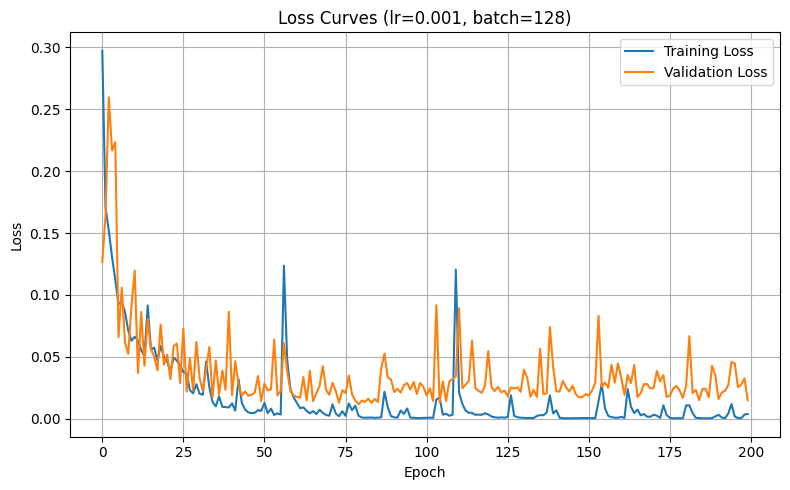

In [ ]:
  # Plot training and validation loss

  plt.figure(figsize=(8, 5))
  plt.plot(train_loss_history, label='Training Loss')
  plt.plot(val_loss_history, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss Curves (lr={learning_rate}, batch={batch_size})')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


In [ ]:
from sklearn.metrics import f1_score  #  Add this at the top if not already done

model.eval()
test_correct = 0
test_total = 0
all_preds = []    #  Store all predictions
all_labels = []   #  Store all ground truth labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())       #  Collect predictions
        all_labels.extend(y_batch.cpu().numpy())    #  Collect true labels

test_acc = test_correct / test_total
test_f1 = f1_score(all_labels, all_preds)           #  Compute F1 score

print(f" Final Test Accuracy: {test_acc:.4%}, F1 Score: {test_f1:.4f}")


 Final Test Accuracy: 95.1714%, F1 Score: 0.9668


In [ ]:
# Plot heatmaps after all runs
def plot_heatmap(matrix, x_labels, y_labels, title, cbar_label):
    plt.figure(figsize=(8, 6))
    # Create the heatmap and assign the returned object to a variable
    # Pass the object to the colorbar
    heatmap = sns.heatmap(matrix, annot=True, fmt=".3f", cmap="YlGnBu",
                xticklabels=x_labels, yticklabels=y_labels, cbar_kws={'label': cbar_label})
    plt.title(title)
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.show()

# Plot validation loss heatmap
plot_heatmap(results['val_loss_matrix'],
             results['batch_sizes'],
             results['learning_rates'],
             "Validation Loss by Hyperparameters",
             "Loss")

# Plot validation accuracy heatmap
plot_heatmap(results['val_acc_matrix'],
             results['batch_sizes'],
             results['learning_rates'],
             "Validation Accuracy by Hyperparameters",
             "Accuracy")

# Plot validation F1 score heatmap
plot_heatmap(results['val_f1_matrix'],
             results['batch_sizes'],
             results['learning_rates'],
             "Validation F1 Score by Hyperparameters",
             "F1 Score")